<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">To be or not to be?</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">Binary Classification on Artificial Medical Data</a></center>
<br/>

---

# Group members

**Minimum 2, Maximum 3**

* CHEN, Haolin
* BAVARO, Stefano
* TORRIJOS ROBLES, Irene


# Presentation of the challenge

## Main question of this challenge

* How to predict the survival of a patient according to their medical files and physiological data?
    
* Specifically, you will need to predict it during their hospital stay
 
Every day, the nursing staff collects information about the patients by asking questions and using measurement tools (stethoscope, blood test, sensors, etc.). These data are very useful for monitoring the state of health, diagnosing, and choosing treatments.

They can also be used for predictive statistical analysis.

## Data

The dataset contains information on 80,000 patients, represented by categorical, binary and, numeric variables (features). These variables are, e.g., age, sex, ethnicity, marital status, as well as medical data such as blood pressure or glucose level. There are a total of 342 variables.

The class to predict is a binary variable indicating whether the patient died or not during his stay in the hospital. Fortunately, most survive:

<!-- #%%[markdown] -->
# ![](img/tobe.png)

References and credit:

Isabelle Guyon, Kristin Bennett, Andrew Yale, Adrien Pavao, Thomas Gerspacher

## Instructions

The link to the challenge:
<https://codalab.lisn.upsaclay.fr/competitions/8802>

* **Step 1:** Register an acount at <https://codalab.lisn.upsaclay.fr>

* **Step 2:** Download the dataset from the [page](https://codalab.lisn.upsaclay.fr/competitions/328#participate-get_starting_kit) `Participate` > `Files` > `Public Data`. Place the `public_data` folder in the same folder as the one containing this notebook.

* **Step 3:** Go through this notebook. You will have to read, execute, **code your own methods** and **answer questions**. Use the ***code*** cell for coding and the ***markdown*** cell to answer questions.

## Project evaluation

* **4 points**: Exploratory analysis

* **4 points**: Clean and well-documented code

* **4 points**: Modeling (selection of the model, selection of hyperparameters)

* **4 points**: Evaluation of the performance of the model

* **4 points**: Quality of the oral presentation

### FAQ

* Submit only the notebook to eCampus (**only 1 per team**)

* The text answers (explanations, results, problems, without the code) must not exceed 1500 words

# Challenge

Prerequisite: `imblearn` (to install with `conda`)

`conda install -c conda-forge imbalanced-learn`

In [1]:
from datetime import datetime
from pathlib import Path

from sklearn.preprocessing import LabelEncoder
import imblearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import (
    decomposition,
    discriminant_analysis,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
    preprocessing,
    svm,
)

In [2]:
%reload_ext autoreload
%autoreload 2

# Set precision for pd and np (np: suppress also sci notation)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = "{:,.4g}".format

print(sklearn.__version__)  # Version tested on sklearn.__version__ == 1.1.3

1.1.3


## 1. Understanding the problem

### Metric

Why the metric used here is the [`sklearn.metrics.balanced_accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) rather than simply [`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)?

The labels of our dataset are unbalanced: indeed, over 79999 entries, 77202 (96.5%) are labeled as 0 and just 2797 (3.5%) are labeled as 1.
The accuracy score is just is the number of correct predictions as a percentage of the number of observations in the dataset: being it easy to compute and understand, it is one of the most common metric used for evaluating classifier models. Though, it can become an unreliable measure of model performance if the class distribution is severely skewed because it does not distinguish between the numbers of correctly classified examples of different classes.
To explain its behaviour better, consider the case of an imbalanced dataset with a 1:100 class imbalance: each example of the minority class (class 1) will have a corresponding 100 examples for the majority class (class 0). On this problem, a model that predicts the majority class for all examples in the test set will have a classification accuracy of 99 percent: though, in problems of this type, predicting the minority class is often preferred since it represents "abnormal" concepts that need to be classified correctly (a false positive is less impactful than a false negative). Therefore, such an high metric might in practice be misleading.
In comparison, balanced accuracy results more suitable for unbalanced datasets: it is computed (in binary classification, like in the context of our problem) as the average of "Sensitivity" (True Positives rate, the probability of a positive case being accurately classed as being positive) and "Specificity" (True Negatives rate, the probability of a negative case being accuracy classed as negative). This way, a model that only predicts accurately the majority class of an imbalanced dataset will receive a worse balanced accuracy score than the accuracy score.

## 2. Data loading

In [3]:
DATA = Path("public_data")
assert DATA.is_dir()

PRED_PATH = Path("Submissions")

DROP_FTS = ["ADMITTIME", "DISCHTIME", "SUBJECT_ID", "HADM_ID"]

In [4]:
features = pd.read_csv(
    DATA / "mimic_synthetic_feat.name", header=None
).values.flatten()

labels = pd.read_csv(
    DATA / "mimic_synthetic_label.name", header=None
).values.flatten()

x_df = pd.read_csv(
    DATA / "mimic_synthetic_train.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_df.drop(columns=DROP_FTS, inplace=True)

ys = pd.Series(
    pd.read_csv(
        DATA / "mimic_synthetic_train.solution",
        header=None,
        names=labels,
        sep=" ",
    ).values.flatten()
)

In [5]:
x_df

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.21,108.7,70.84,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.33,121.1,96.92,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118.2,175.2,140.9,...,0,0,0,0,0,0,0,0,0,0
3,Medicare,ENGL,NOT_SPECIFIED,MARRIED,WHITE,M,75,83.78,89.19,86.05,...,0,0,0,0,0,0,0,0,1,0
4,Medicare,ENGL,UNOBTAINABLE,MARRIED,UNKNOWN/NOT_SPECIFIED,F,55,60.88,105.6,80.62,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79994,Medicare,ENGL,NOT_SPECIFIED,UNKNOWN_(DEFAULT),WHITE,F,76,56.04,97.86,79.71,...,0,0,0,0,0,0,0,0,1,0
79995,Medicaid,ENGL,JEWISH,MARRIED,WHITE,F,38,55.13,86.03,67.65,...,0,0,0,0,0,1,0,0,0,0
79996,Private,ENGL,NOT_SPECIFIED,SEPARATED,WHITE,F,90,74.28,91.27,91.43,...,0,0,0,0,0,0,0,0,0,0
79997,Government,ENGL,CATHOLIC,MARRIED,BLACK/AFRICAN_AMERICAN,M,57,79.26,129,98.74,...,0,0,0,0,0,0,0,0,1,0


In [6]:
x_df.describe()

,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,SYS_BP_MIN_DAY1,SYS_BP_MAX_DAY1,SYS_BP_MEAN_DAY1,DIAS_BP_MIN_DAY1,DIAS_BP_MAX_DAY1,DIAS_BP_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
count,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,...,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04
mean,62.66,71.65,103.1,86.39,94.61,147.8,119.7,45.24,81.99,60.84,...,0,1.25e-05,0,0,0,0.1455,0.1342,0.008625,0.4577,0.07898
std,18.19,14.65,18.48,15.51,16.94,21.61,16.49,10.5,16.64,10.27,...,0,0.003536,0,0,0,0.3526,0.3408,0.09247,0.4982,0.2697
min,16,18.73,49.86,38.5,31.77,91.69,73.97,11.33,42.43,30.5,...,0,0,0,0,0,0,0,0,0,0
25%,51,61.46,89.9,75.28,82.81,132.1,107.6,37.83,69.96,53.4,...,0,0,0,0,0,0,0,0,0,0
50%,65,71.05,101.6,85.42,94.17,145.4,118.1,44.62,79.86,60.1,...,0,0,0,0,0,0,0,0,0,0
75%,77,81.15,114.8,96.51,106,161.1,130.3,51.97,91.76,67.41,...,0,0,0,0,0,0,0,0,1,0
max,90,141.9,206.6,157.6,163.8,260,186.3,95.6,189,109.6,...,0,1,0,0,0,1,1,1,1,1


In [8]:
#x_df.columns.values

In [9]:
x_df['Alcohol-relateddisorders'].describe()

count     8e+04
mean    0.01731
std      0.1304
min           0
25%           0
50%           0
75%           0
max           1
Name: Alcohol-relateddisorders, dtype: float64

This is **the training set**. This means that you have access to the labels and can use it however you want to prepare your model.

Later, you will have your model draw predictions from **the test set** in order to upload them to Codalab and get a score on data not seen while training the models.

In [10]:
# Load test set
x_test_df = pd.read_csv(
    DATA / "mimic_synthetic_test.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_test_df.drop(columns=DROP_FTS, inplace=True)

In [11]:
x_test_df

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Self_Pay,ENGL,OTHER,MARRIED,WHITE,F,18,72.64,112.7,96.46,...,0,0,0,0,0,0,0,0,0,0
1,Medicare,ENGL,NOT_SPECIFIED,SINGLE,BLACK/AFRICAN_AMERICAN,F,56,66.61,106.8,83.85,...,0,0,0,0,0,0,0,0,1,0
2,Medicaid,ENGL,CATHOLIC,SINGLE,WHITE,M,32,69.72,102.7,87.26,...,0,0,0,0,0,0,0,0,0,0
3,Private,ENGL,OTHER,MARRIED,WHITE,M,80,63.28,85.75,76.75,...,0,0,0,0,0,0,0,0,0,0
4,Medicare,ENGL,JEWISH,WIDOWED,WHITE,M,83,75.23,104.4,94.18,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19996,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,M,85,51.54,72.39,69.96,...,0,0,0,0,0,0,0,0,1,0
19997,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,M,69,61.79,75.33,80.25,...,0,0,0,0,0,1,0,0,1,0
19998,Medicare,ENGL,CHRISTIAN_SCIENTIST,MARRIED,UNKNOWN/NOT_SPECIFIED,M,84,94.34,132.7,115.4,...,0,0,0,0,0,0,0,0,0,0
19999,Private,ENGL,PROTESTANT_QUAKER,MARRIED,BLACK/AFRICAN_AMERICAN,M,84,48.68,85.93,57.75,...,0,0,0,0,0,0,1,0,0,0


## 3. Exploratory analysis

#### Features' types

In [12]:
types = pd.read_csv(DATA / "mimic_synthetic_feat.type", header=None).set_index(
    features
)[0]

types.value_counts()

Numerical      226
Binary         107
Categorical      8
Name: 0, dtype: int64

In [13]:
types.head(-10)

SUBJECT_ID       Numerical
HADM_ID          Numerical
ADMITTIME      Categorical
DISCHTIME      Categorical
INSURANCE      Categorical
                  ...     
Cataract         Numerical
Retinaldx           Binary
Glaucoma            Binary
Blindness        Numerical
SexualInfxs      Numerical
Name: 0, Length: 331, dtype: object

#### Target feature distribution

In [14]:
ys.describe()

count     8e+04
mean    0.03496
std      0.1837
min           0
25%           0
50%           0
75%           0
max           1
dtype: float64

### Code: Produce the following graphs

* Bar chart to show the target feature distribution

* Bar charts of 4 categorical variables (e.g., "LANGUAGE", "MARITAL_STATUS")

* Show the correlation between a selection of features and the target feature y

* Another graph or any exploratory analysis you can think of

Text(0.5, 1.0, 'Target distribution')

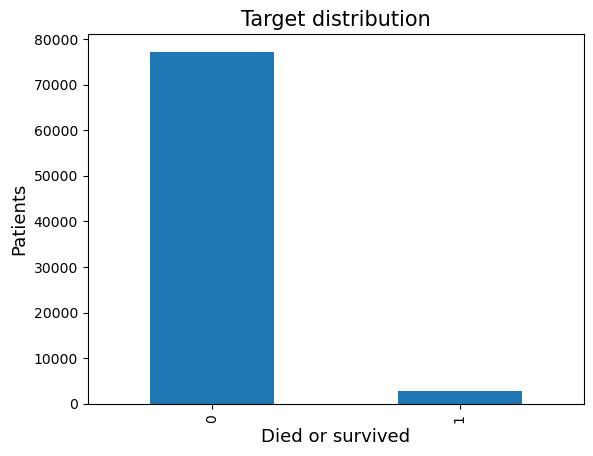

In [15]:
#bar chart target - feature distribution

ys.value_counts().plot(kind='bar')
plt.xlabel('Died or survived', size = 13)
plt.ylabel('Patients', size = 13)
plt.title('Target distribution', size = 15)

<AxesSubplot: >

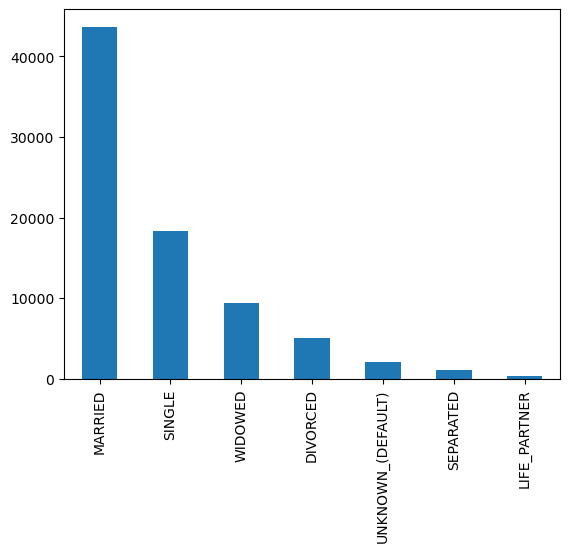

In [16]:
x_df['MARITAL_STATUS'].value_counts().plot(kind='bar')

<AxesSubplot: >

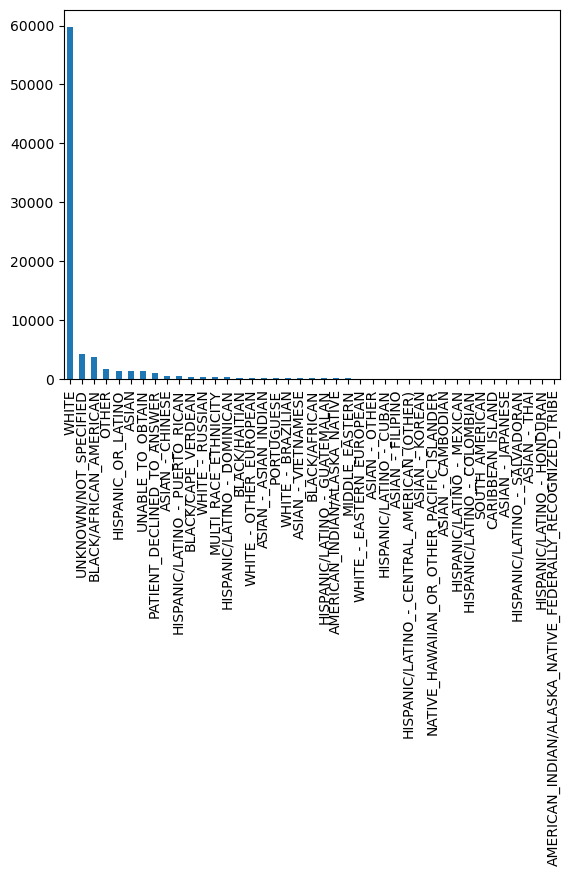

In [17]:
x_df['ETHNICITY'].value_counts().plot(kind='bar')

<AxesSubplot: >

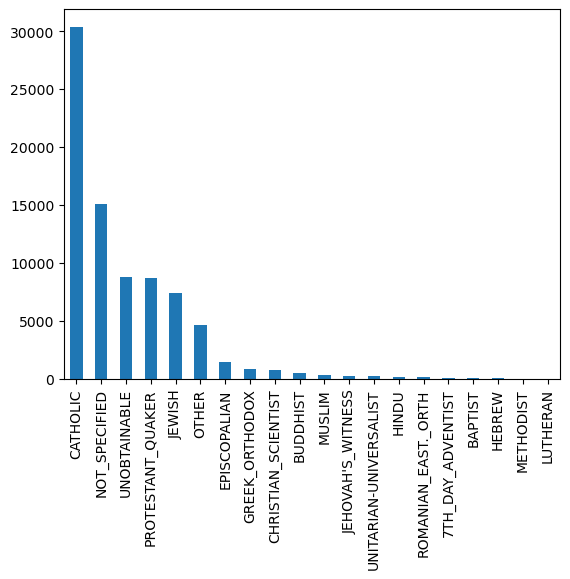

In [18]:
x_df['RELIGION'].value_counts().plot(kind='bar')

<AxesSubplot: >

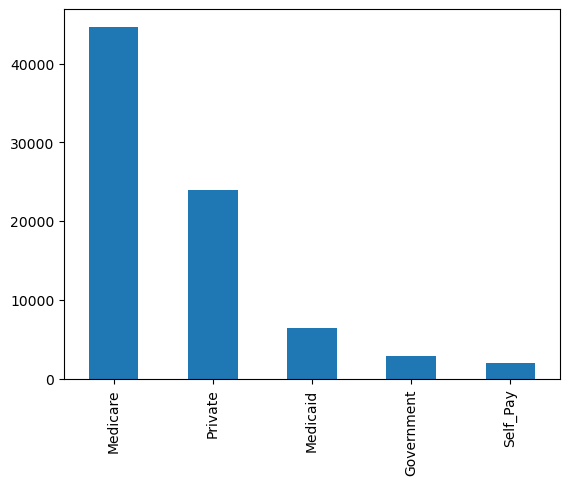

In [19]:
x_df['INSURANCE'].value_counts().plot(kind='bar')

## Show the correlation between a selection features and the target feature y

C:\Users\stefa\AppData\Local\Temp\ipykernel_22952\3288241118.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_columns = corr_columns.append({'feature': c, 'corr':corr, 'corr.abs':abs(corr)}, ignore_index=True)
C:\Users\stefa\AppData\Local\Temp\ipykernel_22952\3288241118.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_columns = corr_columns.append({'feature': c, 'corr':corr, 'corr.abs':abs(corr)}, ignore_index=True)
C:\Users\stefa\AppData\Local\Temp\ipykernel_22952\3288241118.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_columns = corr_columns.append({'feature': c, 'corr':corr, 'corr.abs':abs(corr)}, ignore_index=True)
C:\Users\stefa\AppData\Local\Temp\ipykernel_22952\3288241118.py:8: FutureWarnin

<AxesSubplot: >

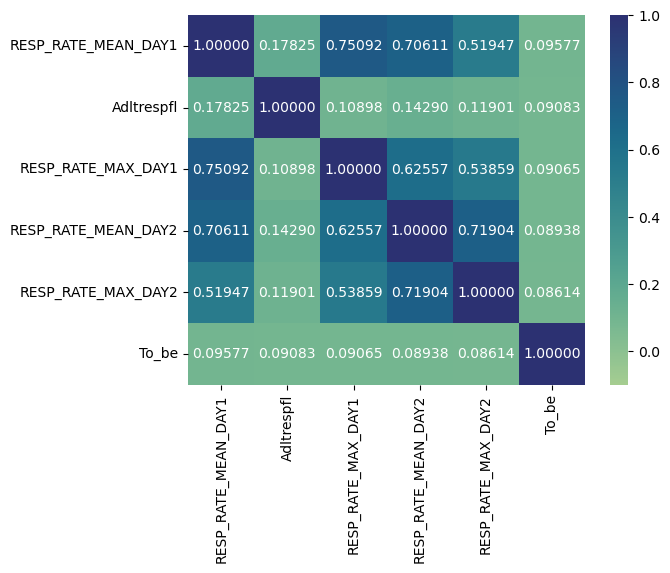

In [20]:
corr_columns = pd.DataFrame(columns = ['feature','corr','corr.abs'])

# calculate correlation between every feature an target
for c in x_df.columns:
  try:
    corr = x_df[c].corr(ys)
    # print(c,corr)
    corr_columns = corr_columns.append({'feature': c, 'corr':corr, 'corr.abs':abs(corr)}, ignore_index=True)
  except:
    pass

# select top 5 features 
select_feature = corr_columns.sort_values(by=['corr.abs'],ascending=False)[0:5].feature
select_feature_corr_df = pd.DataFrame()
for i in select_feature:
  select_feature_corr_df[i] = x_df[i]

# calculate top 5 features correlation matrix
select_feature_ys_df = pd.merge(select_feature_corr_df,pd.DataFrame(ys,columns = ['To_be']),left_index=True,right_index=True)
select_feature_ys_df.corr()

# show the heatmap
sns.heatmap(select_feature_ys_df.corr(),annot=True,fmt=".5f",vmin=1, vmax=0,cmap="crest")

## 4. Preprocessing

### Code: Missing values handling

The simplest solution is to eliminate all the columns where there is missing data, but a large part of the information may be lost.

If a small number of instances is concerned, it is more pertinent to delete the rows (instances) rather than the entire columns (variables). But you need to **pay attention**, if you **cannot** change the number of rows in the **test set**, or the competition grader will **fail**.

A third solution would be to replace undefined values with the most probable value of the variable. As these missing values relate exclusively to categorical and binary variables, the most probable value is the [*mode*](https://en.wikipedia.org/wiki/Mode_(statistics)).

A first baseline version is given, but it should be improved. It discards all categorical features and instances with NAN.

In [21]:
print(x_df.shape, x_test_df.shape)

x_baseline_df = x_df.select_dtypes([np.number]).copy()
x_baseline_test_df = x_test_df.select_dtypes([np.number]).copy()

x_baseline_df.fillna(0, inplace=True)
x_baseline_test_df.fillna(0, inplace=True)

print(x_baseline_df.shape, x_baseline_test_df.shape)

(79999, 337) (20001, 337)
(79999, 330) (20001, 330)


#### Exploration

First check the number of missing data per features and per instances (patient). Don't forget to process both the training and the test sets!

In [22]:
# na values
print('Amount of NaN for each feature')
for feature in x_df.columns.values:
    feature_NaN_train = x_df[feature].isna().sum()
    feature_NaN_test = x_test_df[feature].isna().sum()
    if(feature_NaN_train>0)or (feature_NaN_test>0):
      print(f'TRAIN \n {feature} : {np.round(feature_NaN_train)}')
      print(f'TEST \n {feature} : {np.round(feature_NaN_test)}')


Amount of NaN for each feature
TRAIN 
 LANGUAGE : 1
TEST 
 LANGUAGE : 2
TRAIN 
 MARITAL_STATUS : 1
TEST 
 MARITAL_STATUS : 0
TRAIN 
 ICU : 2
TEST 
 ICU : 0
TRAIN 
 ECodes:Adverseeffectsofmedicalcare : 6
TEST 
 ECodes:Adverseeffectsofmedicalcare : 3
TRAIN 
 Otnutritdx : 2
TEST 
 Otnutritdx : 0
TRAIN 
 Othnervdx : 1
TEST 
 Othnervdx : 0


In [23]:
nan_rows = x_df[x_df.isna().any(axis=1)]
print("Row Index, Number of NaN values")
for i,row in nan_rows.iterrows():
    num_NaN = row.isna().sum()
    print(i,":",num_NaN)

Row Index, Number of NaN values
2251 : 1
9983 : 1
10549 : 1
10831 : 1
17012 : 1
23088 : 1
32539 : 1
42762 : 1
53191 : 1
53390 : 1
56772 : 1
61852 : 1
71511 : 1


In [24]:
nan_rows = x_test_df[x_test_df.isna().any(axis=1)]
print("Row Index, Number of NaN values")
for i,row in nan_rows.iterrows():
    num_NaN = row.isna().sum()
    print(i,":",num_NaN)

Row Index, Number of NaN values
10033 : 1
11561 : 1
12912 : 1
17306 : 1
19532 : 1


#### Fixing

Now you can apply your chosen strategy

In [25]:
for feature in x_df.columns.values:
  x_df[feature] = x_df[feature].fillna(x_df[feature].mode()[0])
  x_test_df[feature] = x_test_df[feature].fillna(x_test_df[feature].mode()[0])

#### Removing single-valued variables (constants)

In [26]:
for col in x_df.columns:
    if (x_df[col] == x_df[col][0]).all():
        x_df = x_df.drop([col], axis=1)
        x_test_df = x_test_df.drop([col], axis=1)

### Reduce data scarcity (not enough data per class)

For example, you could simplify data by grouping rare categories.

In [27]:
#Rare features
rate = 0.025
binary = types[types=='Binary'].index
binary = binary.drop('GENDER')
binary = binary.intersection(x_df.columns)
sum_binary = x_df[binary].sum(axis=0)
rare = sum_binary[sum_binary < rate*len(x_df)].index

# create new column
x_df['rare']=x_df[rare].max(axis=1)
x_test_df['rare']=x_test_df[rare].max(axis=1)

# drop ecodes
x_df.drop(columns = rare, inplace = True)
x_test_df.drop(columns = rare, inplace = True)

### Transforming categorical data into integers using two types of encoding

Categorical variables are presented in the form of character strings. Most models will not be able to handle them in such a format.

#### Simple digital encoding

Two of the simplest methods are `LabelEncoder` from Scikit-Learn and` factorize` from pandas. They simply consist of replacing each new category encountered with an integer, starting with 0. This is perhaps not the most efficient method, since it presupposes proximity between the categories coded with close values.

In [28]:
def LabelEncode(data_train, data_test):
    le = LabelEncoder()
    label_encoded_x_df = data_train.copy()
    label_encoded_x_test_df = data_test.copy()
    for col in label_encoded_x_df.select_dtypes(include='O').columns:
        label_encoded_x_df[col]=le.fit_transform(label_encoded_x_df[col])
        label_encoded_x_test_df[col]= le.transform(label_encoded_x_test_df[col])
    return label_encoded_x_df,label_encoded_x_test_df

label_encoded_x_df,label_encoded_x_test_df = LabelEncode(x_df, x_test_df)

#### 1-Hot encoding

Another type of encoding is often more efficient, in particular, it has the advantage of not ordering the classes in a particular way (not necessarily in line with the proximity of these classes to each other).

A pandas method allows this to be done in 1 line of code with the `get_dummies` function.

Exemple d'encodage 1-hot avec la fonction `get_dummies` de pandas (pour MARITAL_STATUS) :

|    |   DIVORCED |   LIFE_PARTNER |   MARRIED |   SEPARATED |   SINGLE |   UNKNOWN_(DEFAULT) |   WIDOWED |
|---:|-----------:|---------------:|----------:|------------:|---------:|--------------------:|----------:|
|  0 |          1 |              0 |         0 |           0 |        0 |                   0 |         0 |
|  1 |          0 |              0 |         0 |           0 |        1 |                   0 |         0 |
|  2 |          0 |              0 |         0 |           0 |        0 |                   0 |         1 |
|  3 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |
|  4 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |

In [29]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
def OneHotEncode(data_train,data_test):
    one_hot_x_df=data_train.copy()
    one_hot_x_test_df = data_test.copy()
    tot_cat = 0
    for col in one_hot_x_df.select_dtypes(include='O').columns:
        ohe = OneHotEncoder()
        transformed_train = ohe.fit_transform(one_hot_x_df[[col]])
        transformed_test = ohe.transform(one_hot_x_test_df[[col]])
        for category in ohe.categories_:
            one_hot_x_df[category] = transformed_train.toarray()
            one_hot_x_test_df[category] = transformed_test.toarray()
        one_hot_x_df= one_hot_x_df.drop(columns=col)
        one_hot_x_test_df= one_hot_x_test_df.drop(columns=col)
    return one_hot_x_df,one_hot_x_test_df

one_hot_x_df,one_hot_x_test_df = OneHotEncode(x_df, x_test_df)

You can choose your preferred way of encoding the categorical data.

### Size reduction via PCA

Test the PCA to reduce the number of dimensions and see if this improves the result.

Before applying the PCA, it is advisable to standardize the data.

In [30]:
def standardizeData(data_train, data_test):
    standardized_df =data_train.copy()
    standardized_test_df =data_test.copy()
    for col in x_df.select_dtypes(include='number').columns:
        if(standardized_df[col].std()!=0):
            standardized_df[col] = (standardized_df[col] - standardized_df[col].mean())/standardized_df[col].std()
        if(standardized_test_df[col].std()!=0):
            standardized_test_df[col] = (standardized_test_df[col] - standardized_test_df[col].mean())/standardized_test_df[col].std()
    return standardized_df, standardized_test_df
standardized_df, standardized_test_df = standardizeData(one_hot_x_df,one_hot_x_test_df)

In [31]:
def applyPCA(components, data_train, data_test):
    N_COMP = components

    pca = decomposition.PCA(n_components=N_COMP)
    xps_train = pca.fit_transform(data_train)
    xps_test = pca.transform(data_test)
    return xps_train,xps_test
xps_train,xps_test = applyPCA(10,standardized_df, standardized_test_df)


Print a graph that represents the first 2 dimensions of PCA and comment briefly.

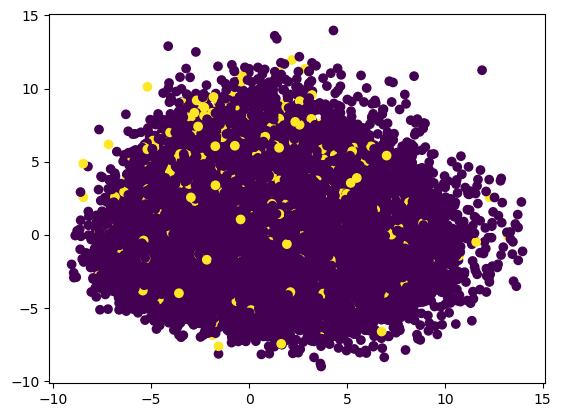

In [32]:
import matplotlib.pyplot as plt
plt.scatter(xps_train[:,0], xps_train[:,1], c=ys)
plt.show()

### Creation of the validation set

In [33]:
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    xps_train, ys, test_size=0.2
)

## 5. Classification models

Train the model

### Baseline

`LogisticRegression` or `RandomForestClassifier`

In [34]:
SCORINGS = "balanced_accuracy"

In [35]:
model_RFC = ensemble.RandomForestClassifier(n_estimators=10)

model_RFC.fit(x_train, y_train)  # training

RandomForestClassifier(n_estimators=10)

In [36]:
# SVM
model_SVM = svm.SVC()
model_SVM.fit(x_train, y_train)

SVC()

In [37]:
from sklearn.naive_bayes import GaussianNB
# GaussianNB
model_gnb = GaussianNB()
model_gnb.fit(x_train, y_train)

GaussianNB()

## 6. Evaluations

In [38]:
y_pred = model_RFC.predict(x_valid)  # predictions

score = metrics.balanced_accuracy_score(y_valid, y_pred)  # scoring

print(f"Balanced accuracy score: {score:.3g}")

Balanced accuracy score: 0.503


In [39]:
# SVM
y_pred_SVM = model_SVM.predict(x_valid)  # predictions

score_SVM = metrics.balanced_accuracy_score(y_valid, y_pred_SVM)  # scoring

print(f"Balanced accuracy score: {score_SVM:.3g}")

Balanced accuracy score: 0.5


In [40]:
# GaussianNB

y_pred_gnb = model_gnb.predict(x_valid)  # predictions

score_gnb = metrics.balanced_accuracy_score(y_valid, y_pred_gnb)  # scoring

print(f"Balanced accuracy score: {score_gnb:.3g}")

Balanced accuracy score: 0.503


### Code: Cross-validation

Use cross-validation (to get a more reliable estimate) combined with an exploration of hyperparameters (to improve results).

You can change the value of the cross-validation number (CV) depending on the error value and the time to train the models (compromise).

In [41]:
def LabelEncode(data):
    le = LabelEncoder()
    label_encoded_x_df = data.copy()
    for col in label_encoded_x_df.select_dtypes(include='O').columns:
        label_encoded_x_df[col]=le.fit_transform(label_encoded_x_df[col])
    return label_encoded_x_df

In [42]:
def OneHotEncode(data):
    one_hot_x_df=data.copy()
    for col in one_hot_x_df.select_dtypes(include='O').columns:
        ohe = OneHotEncoder()
        transformed_train = ohe.fit_transform(one_hot_x_df[[col]])
        for category in ohe.categories_:
            one_hot_x_df[category] = transformed_train.toarray()
        one_hot_x_df= one_hot_x_df.drop(columns=col)
    return one_hot_x_df

In [43]:
def standardizeData(data):
    standardized_df =data.copy()
    for col in x_df.select_dtypes(include='number').columns:
        if(standardized_df[col].std()!=0):
            standardized_df[col] = (standardized_df[col] - standardized_df[col].mean())/standardized_df[col].std()
    return standardized_df

In [44]:
def processData(encoding,data):
    if(encoding == "ordinal"):
            processedData_train= LabelEncode(data)
    elif(encoding == "onehot"):
            processedData_train  = OneHotEncode(data)
    else: 
        return None
    processedData_train= standardizeData(processedData_train)
    return processedData_train

In [45]:
x_train_CV, x_valid_CV, y_train_CV, y_valid_CV = model_selection.train_test_split(
    x_df, ys, test_size=0.2
)

In [46]:
CV = 5
SCORING = "balanced_accuracy"
param_grid = {"pca__n_components": [2, 4, 8, 16, 32, 64]}

x_le_train_CV = processData("ordinal", x_train_CV)
x_ohe_train_CV = processData("onehot", x_train_CV)

pca = decomposition.PCA()
model_gnb_cv = model_gnb
pipe = pipeline.Pipeline(steps=[("pca", pca), ("model", model_gnb_cv)])

search = model_selection.GridSearchCV(
    pipe, param_grid, n_jobs=-1, scoring=SCORINGS, verbose=1, cv=CV
)
CV_GNB_LE = search.fit(x_le_train_CV, y_train_CV)
CV_GNB_OHE = search.fit(x_ohe_train_CV, y_train_CV)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [47]:
param_grid = {"pca__n_components": [8, 16, 32, 64],
              "model__n_estimators": [ 4, 8, 16, 32, 64]}

pca = decomposition.PCA()
model_RFC_cv = model_RFC
pipe = pipeline.Pipeline(steps=[("pca", pca), ("model", model_RFC_cv)])

search = model_selection.GridSearchCV(
    pipe, param_grid, n_jobs=-1, scoring=SCORINGS, verbose=1, cv=CV
)
CV_RFC_LE = search.fit(x_le_train_CV, y_train_CV)
CV_RFC_OHE = search.fit(x_ohe_train_CV, y_train_CV)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [48]:
print(f"Best parameter (CV score: {CV_GNB_LE .best_score_:.3f})")
print(CV_GNB_LE.best_params_)
cv_results_df = pd.DataFrame(CV_GNB_LE .cv_results_)
with pd.option_context("display.float_format", "{:.2g}".format):
    display(cv_results_df)

Best parameter (CV score: 0.551)
{'pca__n_components': 64}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.7,0.33,0.076,0.016,2,{'pca__n_components': 2},0.5,0.5,0.5,0.5,0.5,0.5,0.00011,6
1,2,0.07,0.084,0.0077,4,{'pca__n_components': 4},0.5,0.5,0.5,0.5,0.5,0.5,0.00071,5
2,2.7,0.38,0.1,0.015,8,{'pca__n_components': 8},0.5,0.5,0.5,0.5,0.5,0.5,0.0021,4
3,3.7,0.17,0.16,0.037,16,{'pca__n_components': 16},0.51,0.5,0.5,0.51,0.51,0.51,0.0039,3
4,4.7,0.31,0.22,0.028,32,{'pca__n_components': 32},0.52,0.51,0.53,0.53,0.53,0.52,0.0054,2
5,5.4,0.5,0.14,0.05,64,{'pca__n_components': 64},0.55,0.55,0.55,0.55,0.55,0.55,0.002,1


In [49]:
print(f"Best parameter (CV score: {CV_GNB_OHE .best_score_:.3f})")
print(CV_GNB_OHE.best_params_)
cv_results_df = pd.DataFrame(CV_GNB_OHE .cv_results_)
with pd.option_context("display.float_format", "{:.2g}".format):
    display(cv_results_df)

Best parameter (CV score: 0.551)
{'pca__n_components': 64}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.7,0.33,0.076,0.016,2,{'pca__n_components': 2},0.5,0.5,0.5,0.5,0.5,0.5,0.00011,6
1,2,0.07,0.084,0.0077,4,{'pca__n_components': 4},0.5,0.5,0.5,0.5,0.5,0.5,0.00071,5
2,2.7,0.38,0.1,0.015,8,{'pca__n_components': 8},0.5,0.5,0.5,0.5,0.5,0.5,0.0021,4
3,3.7,0.17,0.16,0.037,16,{'pca__n_components': 16},0.51,0.5,0.5,0.51,0.51,0.51,0.0039,3
4,4.7,0.31,0.22,0.028,32,{'pca__n_components': 32},0.52,0.51,0.53,0.53,0.53,0.52,0.0054,2
5,5.4,0.5,0.14,0.05,64,{'pca__n_components': 64},0.55,0.55,0.55,0.55,0.55,0.55,0.002,1


In [50]:
print(f"Best parameter (CV score: {CV_RFC_LE .best_score_:.3f})")
print(CV_RFC_LE.best_params_)
cv_results_df = pd.DataFrame(CV_RFC_LE .cv_results_)
with pd.option_context("display.float_format", "{:.2g}".format):
    display(cv_results_df)

Best parameter (CV score: 0.502)
{'model__n_estimators': 4, 'pca__n_components': 16}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_estimators,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,7.9,0.65,0.12,0.011,4,8,"{'model__n_estimators': 4, 'pca__n_components'...",0.5,0.5,0.5,0.5,0.5,0.5,0.0014,2
1,10,1.9,0.12,0.039,4,16,"{'model__n_estimators': 4, 'pca__n_components'...",0.5,0.5,0.5,0.5,0.5,0.5,0.0014,1
2,9.8,1.3,0.31,0.14,4,32,"{'model__n_estimators': 4, 'pca__n_components'...",0.5,0.5,0.5,0.5,0.5,0.5,0.0014,3
3,20,0.61,0.16,0.052,4,64,"{'model__n_estimators': 4, 'pca__n_components'...",0.5,0.5,0.5,0.5,0.5,0.5,0.0018,4
4,7.1,0.48,0.13,0.054,8,8,"{'model__n_estimators': 8, 'pca__n_components'...",0.5,0.5,0.5,0.5,0.5,0.5,0.0013,8
5,10,0.28,0.12,0.023,8,16,"{'model__n_estimators': 8, 'pca__n_components'...",0.5,0.5,0.5,0.5,0.5,0.5,0.00095,5
6,13,0.63,0.13,0.013,8,32,"{'model__n_estimators': 8, 'pca__n_components'...",0.5,0.5,0.5,0.5,0.5,0.5,0.00089,7
7,20,0.79,0.15,0.022,8,64,"{'model__n_estimators': 8, 'pca__n_components'...",0.5,0.5,0.5,0.5,0.5,0.5,0.0004,6
8,7.8,0.33,0.15,0.013,16,8,"{'model__n_estimators': 16, 'pca__n_components...",0.5,0.5,0.5,0.5,0.5,0.5,0.00049,12
9,18,0.55,0.2,0.032,16,16,"{'model__n_estimators': 16, 'pca__n_components...",0.5,0.5,0.5,0.5,0.5,0.5,0.00046,11


In [51]:
print(f"Best parameter (CV score: {CV_RFC_OHE .best_score_:.3f})")
print(CV_RFC_OHE.best_params_)
cv_results_df = pd.DataFrame(CV_RFC_OHE .cv_results_)
with pd.option_context("display.float_format", "{:.2g}".format):
    display(cv_results_df)

Best parameter (CV score: 0.502)
{'model__n_estimators': 4, 'pca__n_components': 16}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_estimators,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,7.9,0.65,0.12,0.011,4,8,"{'model__n_estimators': 4, 'pca__n_components'...",0.5,0.5,0.5,0.5,0.5,0.5,0.0014,2
1,10,1.9,0.12,0.039,4,16,"{'model__n_estimators': 4, 'pca__n_components'...",0.5,0.5,0.5,0.5,0.5,0.5,0.0014,1
2,9.8,1.3,0.31,0.14,4,32,"{'model__n_estimators': 4, 'pca__n_components'...",0.5,0.5,0.5,0.5,0.5,0.5,0.0014,3
3,20,0.61,0.16,0.052,4,64,"{'model__n_estimators': 4, 'pca__n_components'...",0.5,0.5,0.5,0.5,0.5,0.5,0.0018,4
4,7.1,0.48,0.13,0.054,8,8,"{'model__n_estimators': 8, 'pca__n_components'...",0.5,0.5,0.5,0.5,0.5,0.5,0.0013,8
5,10,0.28,0.12,0.023,8,16,"{'model__n_estimators': 8, 'pca__n_components'...",0.5,0.5,0.5,0.5,0.5,0.5,0.00095,5
6,13,0.63,0.13,0.013,8,32,"{'model__n_estimators': 8, 'pca__n_components'...",0.5,0.5,0.5,0.5,0.5,0.5,0.00089,7
7,20,0.79,0.15,0.022,8,64,"{'model__n_estimators': 8, 'pca__n_components'...",0.5,0.5,0.5,0.5,0.5,0.5,0.0004,6
8,7.8,0.33,0.15,0.013,16,8,"{'model__n_estimators': 16, 'pca__n_components...",0.5,0.5,0.5,0.5,0.5,0.5,0.00049,12
9,18,0.55,0.2,0.032,16,16,"{'model__n_estimators': 16, 'pca__n_components...",0.5,0.5,0.5,0.5,0.5,0.5,0.00046,11


* **For 2 of the models** (at least 1 other than the proposed baseline):

    * For different values of one of the hyperparameters, give the average `balanced_accuracy` of the cross-validation in the form of Boxplots (or bar graph with an error bar): see the example presented in the graph below.
    
    * Briefly explain what observations to draw concerning the stability of the predictions.

![](img/boxplot-cv.png)

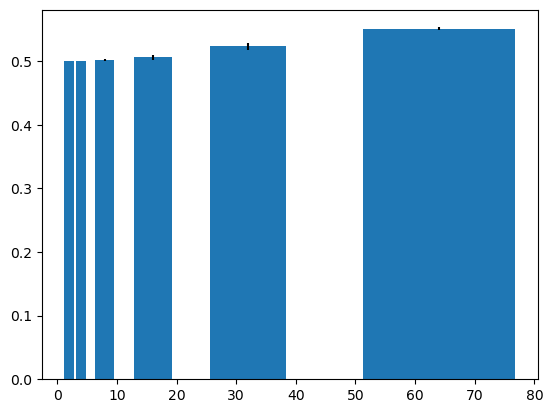

In [76]:
param = CV_GNB_OHE.cv_results_["param_pca__n_components"]

plt.bar(
    CV_GNB_OHE.cv_results_["param_pca__n_components"],
    CV_GNB_OHE.cv_results_["mean_test_score"],
    yerr=CV_GNB_OHE.cv_results_["std_test_score"],
    width=0.8
    * np.diff(CV_GNB_OHE.cv_results_["param_pca__n_components"].data, prepend=0),
)
plt.show()

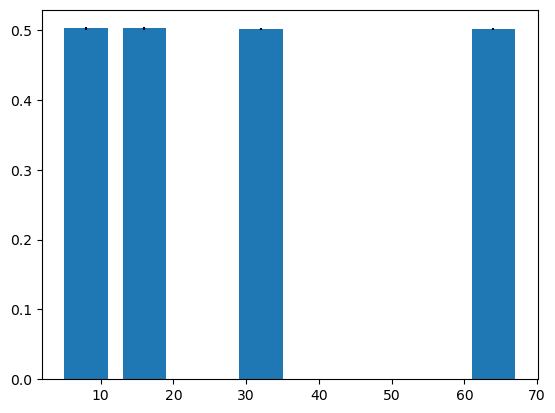

In [83]:
# Plot a bar plot (or boxplot) showing the different prediction scores
# for each tested hyperparameter
# (including the error bars if bar plots are chosen)

param = CV_RFC_OHE.cv_results_["param_pca__n_components"]

plt.bar(
    CV_RFC_OHE.cv_results_["param_pca__n_components"],
    CV_RFC_OHE.cv_results_["mean_test_score"],
    yerr=CV_RFC_OHE.cv_results_["std_test_score"],
    width=6
    #* np.diff(CV_RFC_OHE.cv_results_["param_pca__n_components"].data, prepend=0),
)
plt.show()

* **For each of these 2 models, from the validation data created previously** (`x_valid`,` y_valid`):

    * Measure the area under the ROC curve (AUC) using the Scikit-Learn (`roc_auc_score`) function and compare the models with their respective combination of hyperparameters giving the best result.

In [85]:
from sklearn.metrics import roc_auc_score

data_x_valid = processData("onehot", x_valid_CV)
data_x_valid_gnb= decomposition.PCA(CV_GNB_OHE.best_params_["pca__n_components"]).fit_transform(data_x_valid)
model_gnb_cv_rocauc= GaussianNB().fit(decomposition.PCA(CV_GNB_OHE.best_params_["pca__n_components"]).fit_transform(processData("onehot",x_train_CV)), y_train_CV)
gnb_roc_auc = roc_auc_score(y_valid_CV, model_gnb_cv_rocauc.predict_proba(data_x_valid_gnb)[:, 1])

data_x_valid_rfc= decomposition.PCA(CV_RFC_OHE.best_params_["pca__n_components"]).fit_transform(data_x_valid)
model_RFC_cv_rocauc = ensemble.RandomForestClassifier(n_estimators=CV_RFC_OHE.best_params_["model__n_estimators"]).fit(decomposition.PCA(CV_RFC_OHE.best_params_["pca__n_components"]).fit_transform(processData("onehot",x_train_CV)), y_train_CV)
rfc_roc_auc = roc_auc_score(y_valid_CV, model_RFC_cv_rocauc.predict_proba(data_x_valid_rfc)[:, 1])

print("AUC for GNB model:",gnb_roc_auc)
print("AUC for RFC model:",rfc_roc_auc)


AUC for GNB model: 0.6666022981734077
AUC for RFC model: 0.5521822828449784


* **For the model and its combination of hyperparameters offering the best result**:

    * Present the confusion matrix and describe it succinctly.

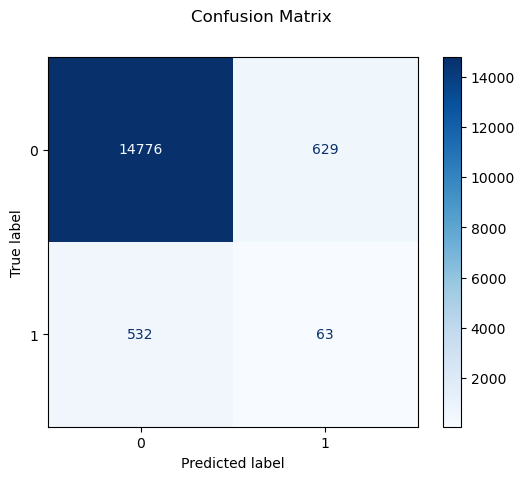

In [86]:

disp = metrics.ConfusionMatrixDisplay.from_estimator(
    model_gnb_cv_rocauc, data_x_valid_gnb, y_valid_CV, cmap=plt.cm.Blues
)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

### Code: Try to improve your score

* Data augmentation (optional)

Given the imbalance between the classes to predict (survive, died), we can hope to improve the score by rebalancing them. A typical approach is through data generation. One of the generation methods is [SMOTE](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#SMOTE). For instance, it is implemented in the `imblearn` library.

`imblearn` was developed to fit the `sklearn` API.
In particular, it offers a version of the `pipeline` which allows integration with `sklearn`.

In [ ]:
ys.value_counts()

0    77202
1     2797
dtype: int64

In [ ]:
# to improve the score we have to deal with imbalanced dataset
from imblearn.under_sampling import RandomUnderSampler

# First, let us try under-sampling the larger group
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
x_under, y_under = undersample.fit_resample(x_train, y_train)

In [ ]:
print(np.shape(x_under),np.shape(y_under))

(4414, 10) (4414,)


In [ ]:
# random forest
model_rf_under = ensemble.RandomForestClassifier(n_estimators=10)
model_rf_under.fit(x_under, y_under)  # training

# random forest
y_pred_rf_under = model_rf_under.predict(x_valid)  # predictions

score_under = metrics.balanced_accuracy_score(y_valid, y_pred_rf_under)  # scoring

print(f"Balanced accuracy score: {score_under:.3g}")

Balanced accuracy score: 0.598


In [ ]:
# SVM
model_SVM_under = svm.SVC()
model_SVM_under.fit(x_under, y_under)

# SVM
y_pred_SVM_under = model_SVM_under.predict(x_valid)  # predictions

score_SVM_under = metrics.balanced_accuracy_score(y_valid, y_pred_SVM_under)  # scoring

print(f"Balanced accuracy score: {score_SVM_under:.3g}")

Balanced accuracy score: 0.66


In [ ]:
x_under.shape

(4414, 10)

In [ ]:
# GaussianNB
model_gnb_under = GaussianNB()
model_gnb_under.fit(x_under, y_under)


y_pred_gnb_under = model_gnb_under.predict(x_valid)  # predictions

score_gnb_under = metrics.balanced_accuracy_score(y_valid, y_pred_gnb_under)  # scoring

print(f"Balanced accuracy score: {score_gnb_under:.3g}")

Balanced accuracy score: 0.643


In [ ]:
# Let us try over-sampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
# fit and apply the transform
sm = SMOTE(random_state=42)
x_over, y_over = sm.fit_resample(x_train, y_train)


In [ ]:
print(np.shape(x_over),np.shape(y_over))

(123584, 10) (123584,)


In [ ]:
# random forest
model_rf_over = ensemble.RandomForestClassifier(n_estimators=10)
model_rf_over.fit(x_over, y_over)  # training

# random forest
y_pred_rf_over = model_rf_over.predict(x_valid)  # predictions

score_over = metrics.balanced_accuracy_score(y_valid, y_pred_rf_over)  # scoring

print(f"Balanced accuracy score: {score_over:.3g}")

Balanced accuracy score: 0.53


In [ ]:
# SVM
model_SVM_over = svm.SVC()
model_SVM_over.fit(x_over, y_over)

# SVM
y_pred_SVM_over = model_SVM_over.predict(x_valid)  # predictions

score_SVM_over = metrics.balanced_accuracy_score(y_valid, y_pred_SVM_over)  # scoring

print(f"Balanced accuracy score: {score_SVM_over:.3g}")

Balanced accuracy score: 0.598


In [ ]:
# GaussianNB
model_gnb_over = GaussianNB()
model_gnb_over.fit(x_over, y_over)


y_pred_gnb_over = model_gnb_over.predict(x_valid)  # predictions

score_gnb_over = metrics.balanced_accuracy_score(y_valid, y_pred_gnb_over)  # scoring

print(f"Balanced accuracy score: {score_gnb_over:.3g}")

Balanced accuracy score: 0.608


### Explanation of what you have achieved, conclusion and perspectives

Start by giving your best result obtained during your submissions

Explain the path that led you there

* What you tried:
    * What worked
    * What didn't work and how you fixed it
* What method did you use to choose the hyperparameters?
* Compare the training time of the main models you used?

What would you have done if you had had more time?

## 7. Save the model predictions

* Use the following code to make predictions and to save them as a ZIP file
* Submit this ZIP file to [the challenge site](https://codalab.lisn.upsaclay.fr/competitions/328#participate-submit_results)
(`Participate > Submit/View Results > Submit`)
* The number of submissions is **limited** to **3 per day** and **30 in total!**
* Try your best to be the ***first on the leaderboard!***

<span style="color:red">
    !! Do not forget to modify the command of the prediction according to the data and models chosen !!
</span>

E.g.:

* Data: `x_test_df` or `x_baseline_test_df`

* Model : `model` or `search` (e.g., for `GridSearchCV`)

In [ ]:
testData = decomposition.PCA(n_components=10).fit_transform(processData("onehot", x_test_df))
predictions = model_SVM_under.predict(testData)

#predictions = model_gnb.predict(x_test_df)  # compute predictions

PRED_PATH.mkdir(parents=True, exist_ok=True)

t_stamp = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
submission_fp = PRED_PATH / f"submission_{t_stamp}.zip"

pred_fname = "mimic_synthetic_test.csv"
compr_opts = dict(method="zip", archive_name=pred_fname)

pd.Series(predictions).to_csv(
    submission_fp, compression=compr_opts, index=False, header=False
)

print(f"The submission is ready: {submission_fp}")

The submission is ready: Submissions\submission_2023-01-02T11-16-36.zip


---

# Note on the dataset

The dataset does not contain actual medical data. It is not allowed to share these **confidential data** from ICU patients. To avoid this problem, the data have been replaced with **artificial data**.

To have credible data, they were generated using a generative adversarial network (**GAN**) Wasserstein.

For more information: <br/>
Andrew Yale, Saloni Dash, Ritik Dutta, Isabelle Guyon, Adrien Pavao, et al. [Privacy Preserving Synthetic Health Data](https://hal.inria.fr/hal-02160496/document). ESANN 2019 - European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, Apr 2019, Bruges, Belgium.

---